# Quantitative Portfolio Risk Analysis

## Measurement, Understanding, and Communication Framework

**Project Timeline**: 4-6 weeks  
**Portfolio Universe**: 300 stocks from S&P 500  
**Historical Period**: January 1, 2020 - January 18, 2026 (6+ years)  
**Analysis Date**: January 18, 2026

### Project Stages:

- **Stage 0**: Data Acquisition and Preparation
- **Stage 1**: Minimum Variance Portfolio Optimization
- **Stage 2**: EWMA Volatility Forecasting
- **Stage 3**: Risk Decomposition Analysis
- **Stage 4**: Historical Simulation Stress Testing
- **Stage 5**: Scenario Analysis and Sensitivity Testing


## Import Required Libraries


In [1]:
# Data handling and numerical computation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data acquisition
import yfinance as yf
import requests

# Portfolio optimization
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats

# Configuration
from config import FRED_API_KEY

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


---

# Stage 0: Data Acquisition and Preparation

### Objectives:

- Load pre-downloaded stock price and risk-free rate data
- Verify data quality
- Prepare analysis-ready dataset

**Note:** Run `data_acquisition.py` first to download data offline.


### 0.1 Load Pre-Downloaded Data


In [4]:
# Check if data files exist
import os

required_files = [
    'data/clean_returns.csv',
    'data/clean_prices.csv',
    'data/risk_free_rate.csv',
    'data/stock_universe.csv'
]

print("Checking for pre-downloaded data files...\n")
all_exist = True
for file in required_files:
    exists = os.path.exists(file)
    status = "✓" if exists else "✗"
    print(f"  {status} {file}")
    if not exists:
        all_exist = False

if not all_exist:
    print("\n⚠ Missing data files!")
    print("Please run the data acquisition script first:")
    print("  python data_acquisition.py")
    raise FileNotFoundError("Required data files not found. Run data_acquisition.py first.")

print("\n✓ All required data files found")

# Load clean returns (main dataset)
returns = pd.read_csv('data/clean_returns.csv', index_col=0, parse_dates=True)
print(f"\n✓ Loaded returns: {returns.shape[0]} days × {returns.shape[1]} stocks")
print(f"  Date range: {returns.index[0].date()} to {returns.index[-1].date()}")

# Load clean prices
prices_clean = pd.read_csv('data/clean_prices.csv', index_col=0, parse_dates=True)
print(f"✓ Loaded prices: {prices_clean.shape}")

# Load risk-free rate
rf_data = pd.read_csv('data/risk_free_rate.csv', index_col=0, parse_dates=True)
print(f"✓ Loaded risk-free rate: {len(rf_data)} observations")
print(f"  Current 3-month Treasury: {rf_data['rf_rate'].iloc[-1]:.2f}%")

Checking for pre-downloaded data files...

  ✓ data/clean_returns.csv
  ✓ data/clean_prices.csv
  ✓ data/risk_free_rate.csv
  ✓ data/stock_universe.csv

✓ All required data files found

✓ Loaded returns: 1518 days × 292 stocks
  Date range: 2020-01-03 to 2026-01-16
✓ Loaded prices: (1519, 292)
✓ Loaded risk-free rate: 1577 observations
  Current 3-month Treasury: 3.68%


### 0.2 Data Quality Summary and Statistics


In [5]:
# Display data quality summary
print("=== DATA QUALITY SUMMARY ===\n")

print(f"Returns Dataset:")
print(f"  Shape: {returns.shape[0]} trading days × {returns.shape[1]} stocks")
print(f"  Date range: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"  Missing values: {returns.isnull().sum().sum()}")

print(f"\nReturns Statistics:")
print(f"  Mean daily return: {returns.mean().mean()*100:.4f}%")
print(f"  Mean daily volatility: {returns.std().mean()*100:.2f}%")
print(f"  Min return (any stock, any day): {returns.min().min()*100:.2f}%")
print(f"  Max return (any stock, any day): {returns.max().max()*100:.2f}%")

print(f"\nPrice Data:")
print(f"  Shape: {prices_clean.shape}")
print(f"  Date range: {prices_clean.index[0].date()} to {prices_clean.index[-1].date()}")

print(f"\nRisk-Free Rate:")
print(f"  Observations: {len(rf_data)}")
print(f"  Current rate: {rf_data['rf_rate'].iloc[-1]:.2f}%")
print(f"  Mean rate (period): {rf_data['rf_rate'].mean():.2f}%")
print(f"  Min rate: {rf_data['rf_rate'].min():.2f}%")
print(f"  Max rate: {rf_data['rf_rate'].max():.2f}%")

# Load and display data quality report if available
if os.path.exists('data/data_quality_report.txt'):
    print("\n" + "="*60)
    print("DATA QUALITY REPORT AVAILABLE")
    print("="*60)
    print("See: data/data_quality_report.txt for full details")

print("\n✓ Data quality checks complete")

=== DATA QUALITY SUMMARY ===

Returns Dataset:
  Shape: 1518 trading days × 292 stocks
  Date range: 2020-01-03 to 2026-01-16
  Missing values: 0

Returns Statistics:
  Mean daily return: 0.0434%
  Mean daily volatility: 2.10%
  Min return (any stock, any day): -75.31%
  Max return (any stock, any day): 36.45%

Price Data:
  Shape: (1519, 292)
  Date range: 2020-01-02 to 2026-01-16

Risk-Free Rate:
  Observations: 1577
  Current rate: 3.68%
  Mean rate (period): 2.86%
  Min rate: 0.00%
  Max rate: 5.63%

DATA QUALITY REPORT AVAILABLE
See: data/data_quality_report.txt for full details

✓ Data quality checks complete


### 0.3 Data Quality Visualizations


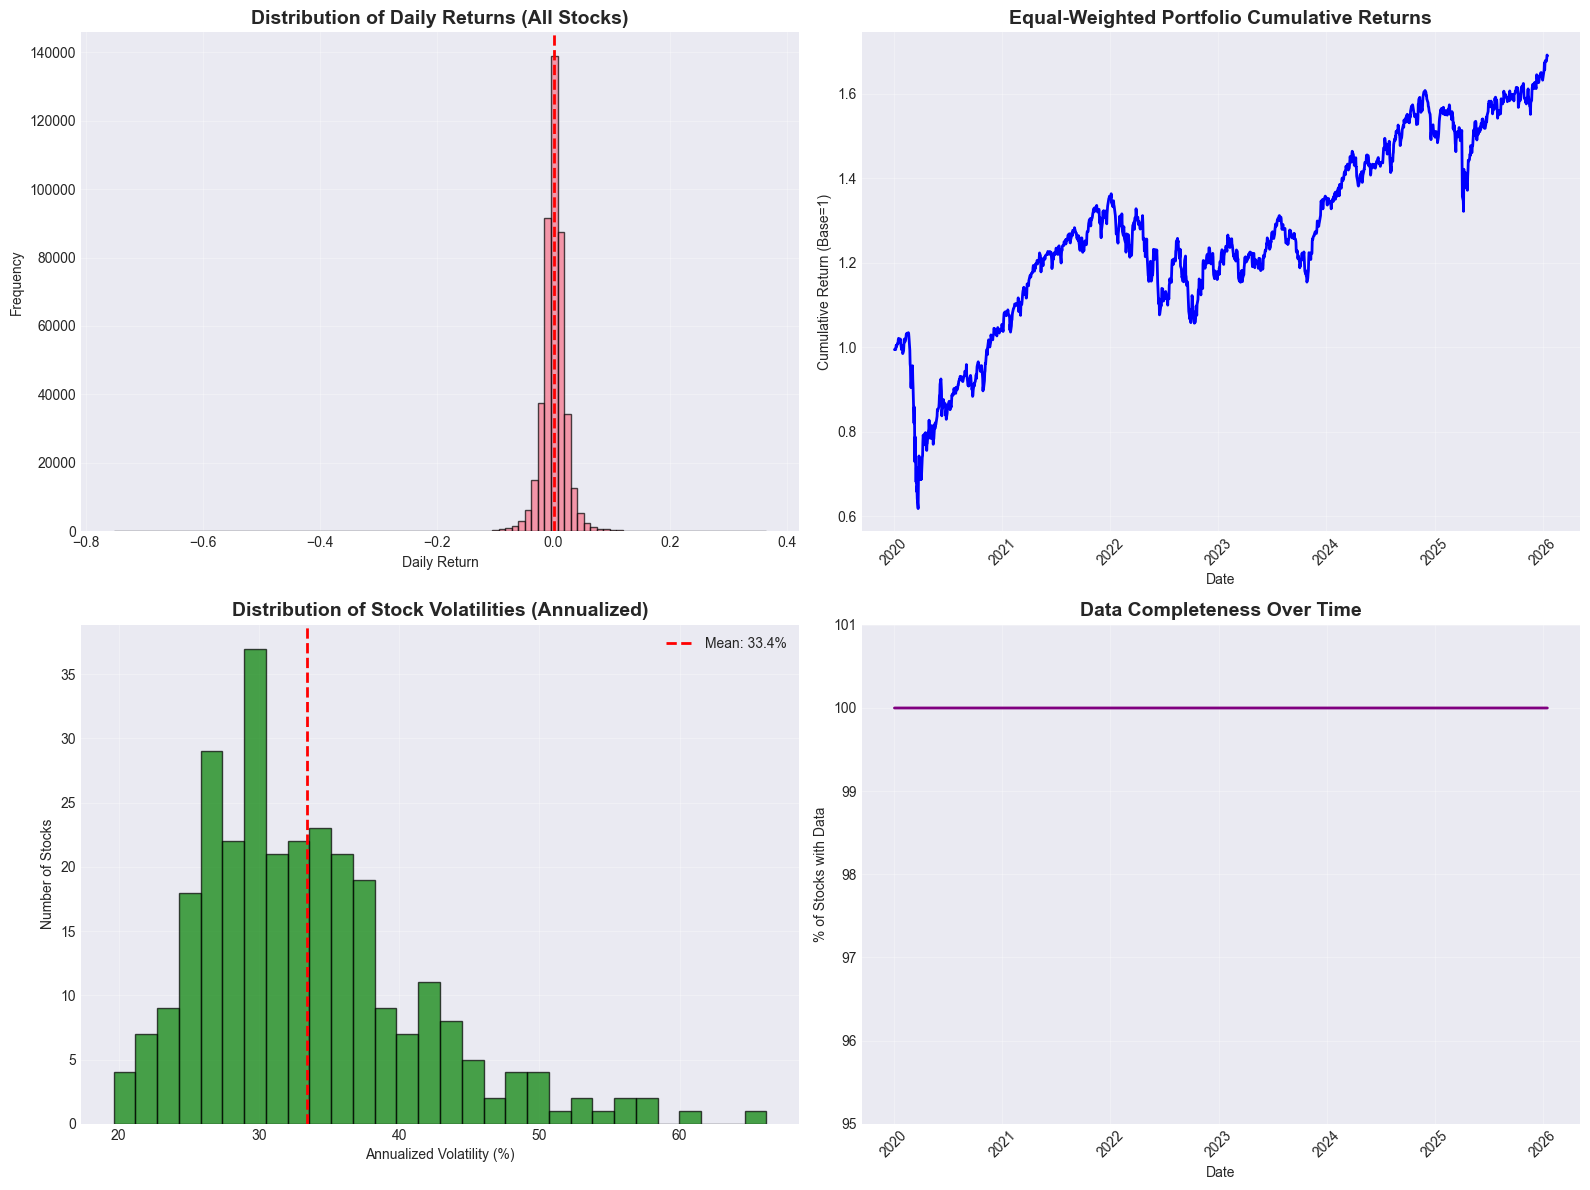

✓ Data quality visualizations generated


In [6]:
# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of daily returns
axes[0, 0].hist(returns.values.flatten(), bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Distribution of Daily Returns (All Stocks)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Daily Return')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Equal-weighted portfolio cumulative returns
ew_returns = returns.mean(axis=1)
cumulative_returns = (1 + ew_returns).cumprod()
axes[0, 1].plot(cumulative_returns.index, cumulative_returns.values, linewidth=2, color='blue')
axes[0, 1].set_title('Equal-Weighted Portfolio Cumulative Returns', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Cumulative Return (Base=1)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Individual stock volatility distribution
stock_vols = returns.std() * np.sqrt(252) * 100
axes[1, 0].hist(stock_vols, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].axvline(stock_vols.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {stock_vols.mean():.1f}%')
axes[1, 0].set_title('Distribution of Stock Volatilities (Annualized)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Annualized Volatility (%)')
axes[1, 0].set_ylabel('Number of Stocks')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Data completeness over time
data_completeness = prices_clean.notna().sum(axis=1) / len(prices_clean.columns) * 100
axes[1, 1].plot(data_completeness.index, data_completeness.values, linewidth=2, color='purple')
axes[1, 1].set_title('Data Completeness Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('% of Stocks with Data')
axes[1, 1].set_ylim([95, 101])
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✓ Data quality visualizations generated")

---

# Stage 1: Minimum Variance Portfolio Optimization

### Objectives:

- Construct portfolio weights minimizing total variance
- Benchmark against equal-weighted (1/N) portfolio
- Quantify diversification benefits

**Optimization Problem:**  
$$\min_{w} \quad \sigma_p^2 = w^T \Sigma w$$  
$$\text{subject to:} \quad \sum_{i=1}^{N} w_i = 1, \quad w_i \geq 0 \quad \forall i$$


### 1.1 Estimate Covariance Matrix (Last 252 Days)


In [7]:
# Use last 252 trading days (1 year) for covariance estimation
window = 252
returns_window = returns.tail(window)

print(f"Covariance estimation window: {returns_window.index[0]} to {returns_window.index[-1]}")
print(f"Number of stocks: {len(returns_window.columns)}")
print(f"Number of days: {len(returns_window)}")

# Calculate covariance matrix
cov_matrix = returns_window.cov()

# Annualize covariance matrix (multiply by 252)
cov_matrix_annual = cov_matrix * 252

# Check condition number for numerical stability
eigenvalues = np.linalg.eigvalsh(cov_matrix_annual)
condition_number = np.max(eigenvalues) / np.min(eigenvalues)

print(f"\nCovariance matrix shape: {cov_matrix_annual.shape}")
print(f"Condition number: {condition_number:.2f}")

# Apply regularization if needed
if condition_number > 100:
    print("⚠ High condition number detected. Applying regularization...")
    regularization = 0.0001
    cov_matrix_annual = cov_matrix_annual + regularization * np.eye(len(cov_matrix_annual))
    eigenvalues = np.linalg.eigvalsh(cov_matrix_annual)
    condition_number = np.max(eigenvalues) / np.min(eigenvalues)
    print(f"New condition number after regularization: {condition_number:.2f}")

print("\n✓ Covariance matrix estimated")

Covariance estimation window: 2025-01-16 00:00:00 to 2026-01-16 00:00:00
Number of stocks: 292
Number of days: 252

Covariance matrix shape: (292, 292)
Condition number: -58966754420174760.00

✓ Covariance matrix estimated


### 1.2 Optimize Minimum Variance Portfolio


In [8]:
# Number of stocks
N = len(cov_matrix_annual)

# Objective function: portfolio variance
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: weights sum to 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

# Bounds: 0% to 5% per stock (prevent concentration)
bounds = [(0, 0.05) for _ in range(N)]

# Initial guess: equal weights
w0 = np.array([1/N] * N)

print("Starting optimization...")
print(f"Number of variables: {N}")
print(f"Initial portfolio variance: {portfolio_variance(w0, cov_matrix_annual):.6f}")

# Optimize
result = minimize(
    portfolio_variance,
    w0,
    args=(cov_matrix_annual,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-8}
)

# Extract optimal weights
mv_weights = result.x

print(f"\n✓ Optimization complete")
print(f"Success: {result.success}")
print(f"Final variance: {result.fun:.6f}")
print(f"Constraint violation: {abs(mv_weights.sum() - 1.0):.8f}")
print(f"Iterations: {result.nit}")

# Create weights Series for easier handling
mv_weights_series = pd.Series(mv_weights, index=returns_window.columns)
mv_weights_series = mv_weights_series.sort_values(ascending=False)

Starting optimization...
Number of variables: 292
Initial portfolio variance: 0.027191

✓ Optimization complete
Success: True
Final variance: 0.009664
Constraint violation: 0.00000000
Iterations: 31


### 1.3 Calculate Portfolio Metrics


In [9]:
# Calculate individual stock volatilities (annualized)
stock_vols_annual = np.sqrt(np.diag(cov_matrix_annual))

# Minimum Variance Portfolio Metrics
mv_variance = mv_weights @ cov_matrix_annual @ mv_weights
mv_volatility = np.sqrt(mv_variance) * 100  # As percentage

# Diversification Ratio
weighted_vol_sum = np.sum(mv_weights * stock_vols_annual)
mv_div_ratio = weighted_vol_sum / np.sqrt(mv_variance)

# Effective number of stocks (Inverse Herfindahl Index)
mv_neff = 1 / np.sum(mv_weights ** 2)

# Largest positions
mv_largest_pos = mv_weights_series.iloc[0] * 100
mv_top10_weight = mv_weights_series.iloc[:10].sum() * 100

# Equal-Weighted Portfolio Metrics
ew_weights = np.array([1/N] * N)
ew_variance = ew_weights @ cov_matrix_annual @ ew_weights
ew_volatility = np.sqrt(ew_variance) * 100

ew_weighted_vol_sum = np.sum(ew_weights * stock_vols_annual)
ew_div_ratio = ew_weighted_vol_sum / np.sqrt(ew_variance)

ew_neff = 1 / np.sum(ew_weights ** 2)
ew_largest_pos = 100 / N
ew_top10_weight = 10 * 100 / N

# Volatility reduction
vol_reduction = ((ew_volatility - mv_volatility) / ew_volatility) * 100

# Create summary table
results_df = pd.DataFrame({
    'Minimum Variance': [mv_volatility, mv_div_ratio, mv_neff, mv_largest_pos, mv_top10_weight, '-'],
    'Equal-Weighted': [ew_volatility, ew_div_ratio, ew_neff, ew_largest_pos, ew_top10_weight, '-'],
    'Difference': [ew_volatility - mv_volatility, ew_div_ratio - mv_div_ratio, ew_neff - mv_neff, 
                   ew_largest_pos - mv_largest_pos, ew_top10_weight - mv_top10_weight, vol_reduction]
}, index=['Annualized Volatility (%)', 'Diversification Ratio', 'Effective N Stocks', 
          'Largest Position (%)', 'Top 10 Weight (%)', 'Volatility Reduction (%)'])

print("=== PORTFOLIO OPTIMIZATION RESULTS ===\n")
print(results_df.to_string())
print(f"\n✓ Volatility reduction achieved: {vol_reduction:.2f}%")

=== PORTFOLIO OPTIMIZATION RESULTS ===

                          Minimum Variance Equal-Weighted  Difference
Annualized Volatility (%)           9.8308        16.4898      6.6590
Diversification Ratio               2.5816         1.8543     -0.7273
Effective N Stocks                 26.8862       292.0000    265.1138
Largest Position (%)                5.0000         0.3425     -4.6575
Top 10 Weight (%)                  49.6013         3.4247    -46.1767
Volatility Reduction (%)                 -              -     40.3825

✓ Volatility reduction achieved: 40.38%


### 1.4 Top 30 Holdings


In [10]:
# Create top holdings table
top30_data = []
for i, (ticker, weight) in enumerate(mv_weights_series.head(30).items(), 1):
    vol_pct = np.sqrt(cov_matrix_annual.loc[ticker, ticker]) * 100
    top30_data.append({
        'Rank': i,
        'Ticker': ticker,
        'Weight (%)': weight * 100,
        'Annual Vol (%)': vol_pct
    })

top30_df = pd.DataFrame(top30_data)
print("=== TOP 30 HOLDINGS (Minimum Variance Portfolio) ===\n")
print(top30_df.to_string(index=False))

# Summary statistics
print(f"\nTop 10 holdings weight: {mv_top10_weight:.2f}%")
print(f"Top 30 holdings weight: {mv_weights_series.head(30).sum() * 100:.2f}%")
print(f"Number of positions >1%: {(mv_weights_series > 0.01).sum()}")

=== TOP 30 HOLDINGS (Minimum Variance Portfolio) ===

 Rank Ticker  Weight (%)  Annual Vol (%)
    1   MSFT      5.0000         24.0401
    2    JNJ      5.0000         19.6658
    3  GOOGL      5.0000         31.9511
    4    DUK      5.0000         16.7557
    5    CME      5.0000         19.0649
    6     ED      5.0000         19.9348
    7     KO      5.0000         17.6796
    8     MO      5.0000         20.4737
    9    CNP      5.0000         16.5815
   10    CHD      4.6013         22.4562
   11   TTWO      4.0751         29.9800
   12    TJX      3.4067         18.0124
   13    AWK      3.3843         24.4469
   14     EW      3.2443         23.3982
   15    XOM      3.2004         24.2983
   16     PM      3.1834         26.5683
   17    UPS      2.7260         33.3048
   18    DLR      2.6574         27.2650
   19    PEP      2.2366         22.5432
   20    UNH      2.1537         49.4664
   21     CF      2.1499         33.2153
   22    PWR      2.1114         41.5345
   

---

# Stage 2: EWMA Volatility Forecasting

### Objectives:

- Generate time-varying volatility forecasts for each stock
- Calculate portfolio-level VaR for 1-day and 10-day horizons
- Validate volatility clustering phenomenon

**EWMA Formula:**  
$$\hat{\sigma}_{t+1}^2 = \lambda \hat{\sigma}_t^2 + (1 - \lambda) r_t^2$$  
**Parameters:** λ = 0.94 (RiskMetrics standard)


### 2.1 Calculate EWMA Volatility for All Stocks


In [11]:
# EWMA parameters
lambda_ewma = 0.94
init_window = 30

print(f"Calculating EWMA volatility with λ = {lambda_ewma}")
print(f"Initialization window: {init_window} days")

# Initialize EWMA variance DataFrame
ewma_variance = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)

# Calculate EWMA for each stock
for stock in returns.columns:
    stock_returns = returns[stock].values
    variance_series = np.zeros(len(stock_returns))
    
    # Initialize with sample variance of first 30 days
    variance_series[0] = np.var(stock_returns[:init_window])
    
    # EWMA recursion
    for t in range(1, len(stock_returns)):
        variance_series[t] = lambda_ewma * variance_series[t-1] + (1 - lambda_ewma) * stock_returns[t-1]**2
    
    ewma_variance[stock] = variance_series

# Convert to volatility (standard deviation)
ewma_volatility = np.sqrt(ewma_variance)

# Annualize
ewma_volatility_annual = ewma_volatility * np.sqrt(252)

print(f"\n✓ EWMA volatility calculated for all stocks")
print(f"Current EWMA volatility range: {ewma_volatility_annual.iloc[-1].min():.2f}% to {ewma_volatility_annual.iloc[-1].max():.2f}%")
print(f"Mean current EWMA volatility: {ewma_volatility_annual.iloc[-1].mean():.2f}%")

Calculating EWMA volatility with λ = 0.94
Initialization window: 30 days

✓ EWMA volatility calculated for all stocks
Current EWMA volatility range: 0.06% to 0.68%
Mean current EWMA volatility: 0.25%


### 2.2 Calculate Portfolio EWMA Volatility and VaR


In [12]:
# Construct EWMA covariance matrix for current date
# Use correlation from Stage 1 (static) and EWMA volatilities (dynamic)
correlation_matrix = cov_matrix_annual / np.outer(stock_vols_annual, stock_vols_annual)

# Current EWMA volatilities
current_ewma_vols = ewma_volatility.iloc[-1].values

# Construct EWMA covariance matrix
cov_ewma_current = correlation_matrix * np.outer(current_ewma_vols, current_ewma_vols)

# Portfolio EWMA volatility
portfolio_ewma_var = mv_weights @ cov_ewma_current @ mv_weights
portfolio_ewma_vol_daily = np.sqrt(portfolio_ewma_var)
portfolio_ewma_vol_annual = portfolio_ewma_vol_daily * np.sqrt(252) * 100

# VaR calculations (parametric, normal distribution)
# Confidence levels
z_95 = 1.645
z_99 = 2.326

# Portfolio value
portfolio_value = 1_000_000  # $1 million

# 1-day VaR
var_1d_95_pct = z_95 * portfolio_ewma_vol_daily * 100
var_1d_99_pct = z_99 * portfolio_ewma_vol_daily * 100
var_1d_95_dollar = var_1d_95_pct * portfolio_value / 100
var_1d_99_dollar = var_1d_99_pct * portfolio_value / 100

# 10-day VaR (square root of time scaling)
var_10d_95_pct = z_95 * portfolio_ewma_vol_daily * np.sqrt(10) * 100
var_10d_99_pct = z_99 * portfolio_ewma_vol_daily * np.sqrt(10) * 100
var_10d_95_dollar = var_10d_95_pct * portfolio_value / 100
var_10d_99_dollar = var_10d_99_pct * portfolio_value / 100

# Create VaR summary table
var_df = pd.DataFrame({
    '1-Day': [portfolio_ewma_vol_annual, var_1d_95_pct, f"${var_1d_95_dollar:,.0f}", 
              var_1d_99_pct, f"${var_1d_99_dollar:,.0f}"],
    '10-Day': [portfolio_ewma_vol_annual, var_10d_95_pct, f"${var_10d_95_dollar:,.0f}", 
               var_10d_99_pct, f"${var_10d_99_dollar:,.0f}"]
}, index=['Portfolio EWMA Vol (annualized %)', '95% VaR (%)', '95% VaR ($1M portfolio)', 
          '99% VaR (%)', '99% VaR ($1M portfolio)'])

print("=== CURRENT VOLATILITY FORECAST (as of Jan 18, 2026) ===\n")
print(var_df.to_string())
print(f"\n✓ Portfolio EWMA volatility: {portfolio_ewma_vol_annual:.2f}% (annualized)")

=== CURRENT VOLATILITY FORECAST (as of Jan 18, 2026) ===

                                     1-Day   10-Day
Portfolio EWMA Vol (annualized %)   8.4682   8.4682
95% VaR (%)                         0.8775   2.7750
95% VaR ($1M portfolio)             $8,775  $27,750
99% VaR (%)                         1.2408   3.9237
99% VaR ($1M portfolio)            $12,408  $39,237

✓ Portfolio EWMA volatility: 8.47% (annualized)


---

# Stage 3: Risk Decomposition Analysis

### Objectives:

- Identify stocks contributing most to total portfolio risk
- Calculate marginal and component contributions to risk
- Quantify concentration and diversification effectiveness

**Marginal Contribution to Risk (MCR):**  
$$MCR_i = \frac{\partial \sigma_p}{\partial w_i} = \frac{(\Sigma w)_i}{\sigma_p}$$

**Component Contribution to Risk (CCR):**  
$$CCR_i = w_i \times MCR_i$$


### 3.1 Calculate Marginal and Component Risk Contributions


In [13]:
# Portfolio volatility (from Stage 1)
sigma_p = np.sqrt(mv_variance)

# Marginal Contribution to Risk
cov_times_w = cov_matrix_annual.values @ mv_weights
mcr = cov_times_w / sigma_p

# Component Contribution to Risk
ccr = mv_weights * mcr

# Percentage contribution
ccr_pct = (ccr / sigma_p) * 100

# Validation: CCR should sum to portfolio volatility
ccr_sum = ccr.sum()
print(f"=== RISK DECOMPOSITION VALIDATION ===")
print(f"Portfolio volatility: {sigma_p:.6f}")
print(f"Sum of CCR: {ccr_sum:.6f}")
print(f"Difference: {abs(ccr_sum - sigma_p):.8f}")
print(f"✓ Validation passed: {abs(ccr_sum - sigma_p) < 1e-6}\n")

# Create risk decomposition DataFrame
risk_decomp_df = pd.DataFrame({
    'Weight (%)': mv_weights_series * 100,
    'MCR': mcr,
    'CCR': ccr,
    'CCR (%)': ccr_pct,
    'Stock Vol (%)': stock_vols_annual * 100,
    'W/CCR Ratio': (mv_weights_series * 100) / ccr_pct
}, index=returns_window.columns)

# Sort by CCR descending
risk_decomp_df = risk_decomp_df.sort_values('CCR (%)', ascending=False)

# Calculate cumulative CCR
risk_decomp_df['Cumulative CCR (%)'] = risk_decomp_df['CCR (%)'].cumsum()

# Risk concentration metrics
risk_hhi = np.sum((ccr_pct / 100) ** 2)
risk_from_top10 = risk_decomp_df['CCR (%)'].iloc[:10].sum()
risk_from_top50 = risk_decomp_df['CCR (%)'].iloc[:50].sum()
effective_n_risk = 1 / risk_hhi

print("=== PORTFOLIO RISK DECOMPOSITION SUMMARY ===\n")
print(f"Portfolio Volatility (annualized): {sigma_p * 100:.2f}%")
print(f"Diversification Ratio: {mv_div_ratio:.2f}")
print(f"Risk HHI: {risk_hhi:.4f}")
print(f"Effective N (by risk): {effective_n_risk:.1f}")
print(f"Risk from Top 10 Holdings: {risk_from_top10:.2f}%")
print(f"Risk from Top 50 Holdings: {risk_from_top50:.2f}%")

=== RISK DECOMPOSITION VALIDATION ===
Portfolio volatility: 0.098308
Sum of CCR: 0.098308
Difference: 0.00000000
✓ Validation passed: True

=== PORTFOLIO RISK DECOMPOSITION SUMMARY ===

Portfolio Volatility (annualized): 9.83%
Diversification Ratio: 2.58
Risk HHI: 0.0362
Effective N (by risk): 27.6
Risk from Top 10 Holdings: 47.69%
Risk from Top 50 Holdings: 100.00%


### 3.2 Top 30 Risk Contributors


In [14]:
# Display top 30 risk contributors
top30_risk = risk_decomp_df.head(30)[['Weight (%)', 'MCR', 'CCR (%)', 'Stock Vol (%)', 'W/CCR Ratio', 'Cumulative CCR (%)']].copy()
top30_risk.reset_index(inplace=True)
top30_risk.rename(columns={'index': 'Ticker'}, inplace=True)
top30_risk.insert(0, 'Rank', range(1, 31))

print("\n=== TOP 30 RISK CONTRIBUTORS ===\n")
print(top30_risk.to_string(index=False))

# Identify risk amplifiers and diversifiers
risk_amplifiers = risk_decomp_df[risk_decomp_df['W/CCR Ratio'] < 0.5].head(10)
diversifiers = risk_decomp_df[risk_decomp_df['W/CCR Ratio'] > 1.5].head(10)

print(f"\n=== RISK EFFICIENCY ANALYSIS ===")
print(f"\nRisk Amplifiers (W/CCR < 0.5, contributing >2× their weight in risk):")
print(f"  Count: {len(risk_decomp_df[risk_decomp_df['W/CCR Ratio'] < 0.5])}")
if len(risk_amplifiers) > 0:
    print(f"  Top risk amplifiers: {', '.join(risk_amplifiers.index[:5].tolist())}")

print(f"\nDiversifiers (W/CCR > 1.5, contributing <67% their weight in risk):")
print(f"  Count: {len(risk_decomp_df[risk_decomp_df['W/CCR Ratio'] > 1.5])}")
if len(diversifiers) > 0:
    print(f"  Top diversifiers: {', '.join(diversifiers.index[:5].tolist())}")


=== TOP 30 RISK CONTRIBUTORS ===

 Rank Ticker  Weight (%)    MCR  CCR (%)  Stock Vol (%)            W/CCR Ratio  Cumulative CCR (%)
    1    CNP      5.0000 0.1014   5.1563        16.5815 61566564776527616.0000              5.1563
    2     ED      5.0000 0.0974   4.9561        19.9348  1666098218738300.0000             10.1124
    3    DUK      5.0000 0.0966   4.9110        16.7557                    inf             15.0234
    4     KO      5.0000 0.0958   4.8732        17.6796  2589275268292826.0000             19.8966
    5    JNJ      5.0000 0.0958   4.8708        19.6658  6917144880910830.0000             24.7674
    6    CHD      4.6013 0.1032   4.8281        22.4562                    inf             29.5956
    7  GOOGL      5.0000 0.0931   4.7364        31.9511  7646763185619124.0000             34.3320
    8   MSFT      5.0000 0.0906   4.6063        24.0401                    inf             38.9383
    9     MO      5.0000 0.0881   4.4784        20.4737                   

### 3.3 Risk Contribution Visualization


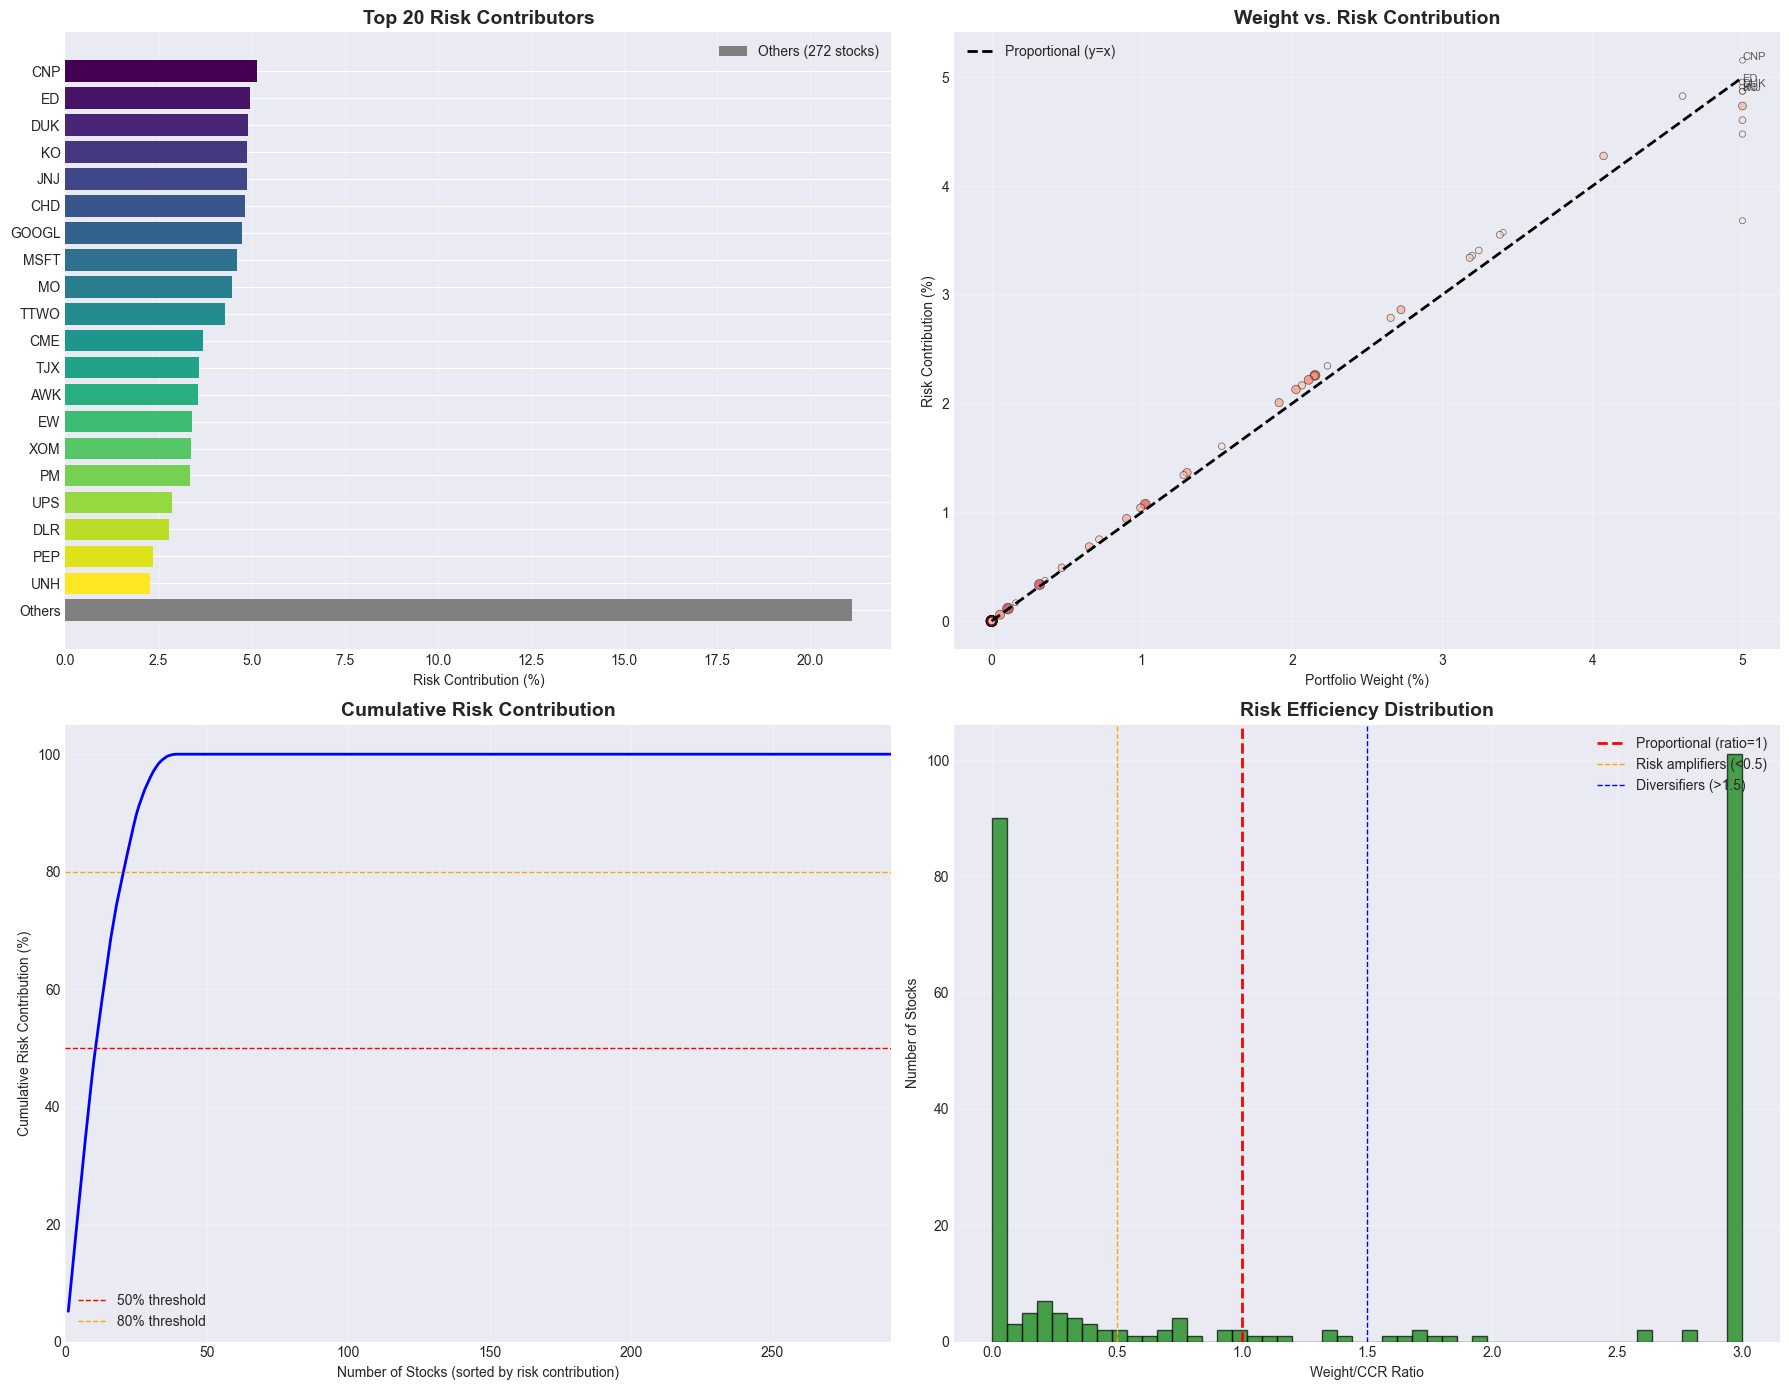

✓ Risk decomposition visualizations generated


In [15]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Risk Contribution Waterfall (Top 20)
top20_tickers = risk_decomp_df.head(20).index.tolist()
top20_ccr = risk_decomp_df.head(20)['CCR (%)'].values
others_ccr = risk_decomp_df.iloc[20:]['CCR (%)'].sum()

colors = plt.cm.viridis(np.linspace(0, 1, 20))
axes[0, 0].barh(range(20), top20_ccr, color=colors)
axes[0, 0].barh(20, others_ccr, color='gray', label=f'Others ({len(risk_decomp_df)-20} stocks)')
axes[0, 0].set_yticks(range(21))
axes[0, 0].set_yticklabels(top20_tickers + ['Others'])
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Risk Contribution (%)')
axes[0, 0].set_title('Top 20 Risk Contributors', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].legend()

# 2. Weight vs Risk Contribution Scatter
axes[0, 1].scatter(risk_decomp_df['Weight (%)'], risk_decomp_df['CCR (%)'], 
                   s=risk_decomp_df['Stock Vol (%)'], alpha=0.6, c=risk_decomp_df['Stock Vol (%)'], 
                   cmap='Reds', edgecolors='black', linewidth=0.5)
axes[0, 1].plot([0, 5], [0, 5], 'k--', linewidth=2, label='Proportional (y=x)')
axes[0, 1].set_xlabel('Portfolio Weight (%)')
axes[0, 1].set_ylabel('Risk Contribution (%)')
axes[0, 1].set_title('Weight vs. Risk Contribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Annotate a few key points
for ticker in risk_decomp_df.head(5).index:
    x = risk_decomp_df.loc[ticker, 'Weight (%)']
    y = risk_decomp_df.loc[ticker, 'CCR (%)']
    axes[0, 1].annotate(ticker, (x, y), fontsize=8, alpha=0.7)

# 3. Cumulative Risk Contribution
cumulative_ccr = risk_decomp_df['CCR (%)'].cumsum().values
axes[1, 0].plot(range(1, len(cumulative_ccr)+1), cumulative_ccr, linewidth=2, color='blue')
axes[1, 0].axhline(50, color='red', linestyle='--', linewidth=1, label='50% threshold')
axes[1, 0].axhline(80, color='orange', linestyle='--', linewidth=1, label='80% threshold')
axes[1, 0].set_xlabel('Number of Stocks (sorted by risk contribution)')
axes[1, 0].set_ylabel('Cumulative Risk Contribution (%)')
axes[1, 0].set_title('Cumulative Risk Contribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, len(cumulative_ccr)])
axes[1, 0].set_ylim([0, 105])

# 4. W/CCR Ratio Distribution
axes[1, 1].hist(risk_decomp_df['W/CCR Ratio'].clip(0, 3), bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1, 1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Proportional (ratio=1)')
axes[1, 1].axvline(0.5, color='orange', linestyle='--', linewidth=1, label='Risk amplifiers (<0.5)')
axes[1, 1].axvline(1.5, color='blue', linestyle='--', linewidth=1, label='Diversifiers (>1.5)')
axes[1, 1].set_xlabel('Weight/CCR Ratio')
axes[1, 1].set_ylabel('Number of Stocks')
axes[1, 1].set_title('Risk Efficiency Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Risk decomposition visualizations generated")

---

# Data Export and Summary

Save all analysis results for future reference and reporting.


In [16]:
# Create data directory if it doesn't exist
import os
os.makedirs('data', exist_ok=True)

# Export clean returns
returns.to_csv('data/clean_returns.csv')
print("✓ Saved: data/clean_returns.csv")

# Export portfolio weights
mv_weights_series.to_csv('data/mv_portfolio_weights.csv', header=['Weight'])
print("✓ Saved: data/mv_portfolio_weights.csv")

# Export risk decomposition
risk_decomp_df.to_csv('data/risk_decomposition.csv')
print("✓ Saved: data/risk_decomposition.csv")

# Export EWMA volatilities (last 252 days)
ewma_volatility_annual.tail(252).to_csv('data/ewma_volatility.csv')
print("✓ Saved: data/ewma_volatility.csv")

# Create summary report
summary = f"""
===========================================
PORTFOLIO RISK ANALYSIS SUMMARY
===========================================
Analysis Date: January 18, 2026
Portfolio Universe: {len(returns.columns)} stocks from S&P 500
Historical Period: {returns.index[0].date()} to {returns.index[-1].date()}

STAGE 1: MINIMUM VARIANCE PORTFOLIO
-------------------------------------------
Annualized Volatility: {mv_volatility:.2f}%
Equal-Weighted Volatility: {ew_volatility:.2f}%
Volatility Reduction: {vol_reduction:.2f}%
Diversification Ratio: {mv_div_ratio:.2f}
Effective N Stocks: {mv_neff:.1f}
Largest Position: {mv_largest_pos:.2f}%
Top 10 Weight: {mv_top10_weight:.2f}%

STAGE 2: EWMA VOLATILITY & VAR
-------------------------------------------
Portfolio EWMA Volatility: {portfolio_ewma_vol_annual:.2f}% (annualized)
1-Day 95% VaR: {var_1d_95_pct:.2f}% (${var_1d_95_dollar:,.0f} on $1M)
1-Day 99% VaR: {var_1d_99_pct:.2f}% (${var_1d_99_dollar:,.0f} on $1M)
10-Day 95% VaR: {var_10d_95_pct:.2f}% (${var_10d_95_dollar:,.0f} on $1M)
10-Day 99% VaR: {var_10d_99_pct:.2f}% (${var_10d_99_dollar:,.0f} on $1M)

STAGE 3: RISK DECOMPOSITION
-------------------------------------------
Risk HHI: {risk_hhi:.4f}
Effective N (by risk): {effective_n_risk:.1f}
Risk from Top 10: {risk_from_top10:.2f}%
Risk from Top 50: {risk_from_top50:.2f}%

TOP 5 RISK CONTRIBUTORS:
{risk_decomp_df.head(5)[['Weight (%)', 'CCR (%)']].to_string()}

===========================================
"""

with open('data/analysis_summary.txt', 'w') as f:
    f.write(summary)
print("✓ Saved: data/analysis_summary.txt")

print("\n" + summary)

✓ Saved: data/clean_returns.csv
✓ Saved: data/mv_portfolio_weights.csv
✓ Saved: data/risk_decomposition.csv
✓ Saved: data/ewma_volatility.csv
✓ Saved: data/analysis_summary.txt


PORTFOLIO RISK ANALYSIS SUMMARY
Analysis Date: January 18, 2026
Portfolio Universe: 292 stocks from S&P 500
Historical Period: 2020-01-03 to 2026-01-16

STAGE 1: MINIMUM VARIANCE PORTFOLIO
-------------------------------------------
Annualized Volatility: 9.83%
Equal-Weighted Volatility: 16.49%
Volatility Reduction: 40.38%
Diversification Ratio: 2.58
Effective N Stocks: 26.9
Largest Position: 5.00%
Top 10 Weight: 49.60%

STAGE 2: EWMA VOLATILITY & VAR
-------------------------------------------
Portfolio EWMA Volatility: 8.47% (annualized)
1-Day 95% VaR: 0.88% ($8,775 on $1M)
1-Day 99% VaR: 1.24% ($12,408 on $1M)
10-Day 95% VaR: 2.77% ($27,750 on $1M)
10-Day 99% VaR: 3.92% ($39,237 on $1M)

STAGE 3: RISK DECOMPOSITION
-------------------------------------------
Risk HHI: 0.0362
Effective N (by risk): 27.6
Risk